#Experiment 5: XGBoost / LightGBM (No Mitigation)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Step 0: Setup Environment

In [ ]:

# Install required libraries
!pip install xgboost lightgbm shap aif360 scikit-learn pandas matplotlib seaborn --quiet

# Imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import shap
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from aif360.datasets import StandardDataset
from aif360.metrics import ClassificationMetric


## Step 1: Load and Preprocess LendingClub Dataset

In [ ]:

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/Research_Thesis_Implementation/data_final/lendingclub_data.csv')

# Select relevant columns
selected_cols = ['loan_status', 'annual_inc', 'term', 'grade', 'home_ownership', 'purpose', 'zip_code']
df = df[selected_cols].dropna()

# Convert target to binary
df['loan_status'] = df['loan_status'].apply(lambda x: 1 if x == 'Fully Paid' else 0)

# Encode categorical features
for col in ['term', 'grade', 'home_ownership', 'purpose', 'zip_code']:
    df[col] = LabelEncoder().fit_transform(df[col])

# Normalize income
df['annual_inc'] = StandardScaler().fit_transform(df[['annual_inc']])


/tmp/ipython-input-3341130038.py:2: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/Research_Thesis_Implementation/data_final/lendingclub_data.csv')


##Step 2: Create AIF360 Dataset

In [ ]:

privileged_groups = [{'zip_code': 1}]
unprivileged_groups = [{'zip_code': 0}]

aif_data = StandardDataset(df,
                           label_name='loan_status',
                           favorable_classes=[1],
                           protected_attribute_names=['zip_code'],
                           privileged_classes=[[1]])


## Step 3: Train XGBoost or LightGBM

In [ ]:

X = aif_data.features
y = aif_data.labels.ravel()

# Choose model: XGBoost or LightGBM
clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
# clf = LGBMClassifier(random_state=42)  # Uncomment to use LightGBM instead

clf.fit(X, y)
y_pred = clf.predict(X)
y_prob = clf.predict_proba(X)[:, 1]


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [09:37:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


## Step 4: Evaluate Performance and Fairness

In [ ]:

print("Accuracy:", accuracy_score(y, y_pred))
print("Precision:", precision_score(y, y_pred))
print("Recall:", recall_score(y, y_pred))
print("F1 Score:", f1_score(y, y_pred))
print("AUC-ROC:", roc_auc_score(y, y_prob))

pred_dataset = aif_data.copy()
pred_dataset.labels = y_pred.reshape(-1, 1)

metric = ClassificationMetric(aif_data, pred_dataset,
                              unprivileged_groups=unprivileged_groups,
                              privileged_groups=privileged_groups)

print("Statistical Parity Difference:", metric.statistical_parity_difference())
print("Disparate Impact:", metric.disparate_impact())
print("Equal Opportunity Difference:", metric.equal_opportunity_difference())
print("Average Odds Difference:", metric.average_odds_difference())
print("Bias Amplification:", metric.between_group_generalized_entropy_index())
print("Theil Index:", metric.theil_index())


Accuracy: 0.9072
Precision: 0.9130434782608695
Recall: 0.9642562551553479
F1 Score: 0.9379513238833913
AUC-ROC: 0.9647157858893401
Statistical Parity Difference: -0.07692307692307687
Disparate Impact: 0.9230769230769231
Equal Opportunity Difference: 0.0
Average Odds Difference: -0.5
Bias Amplification: 170.3984375
Theil Index: 0.04898466320083685


## Step 5: SHAP Explainability (Global & Subgroup)

ExactExplainer explainer: 5001it [02:09, 36.70it/s]                          


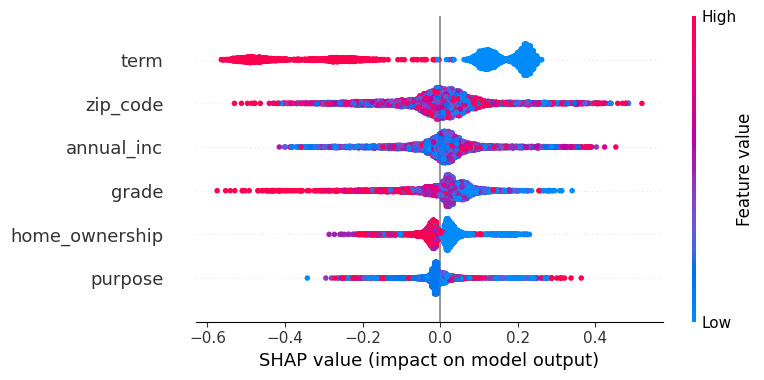

Privileged rows: 2
Unprivileged rows: 13


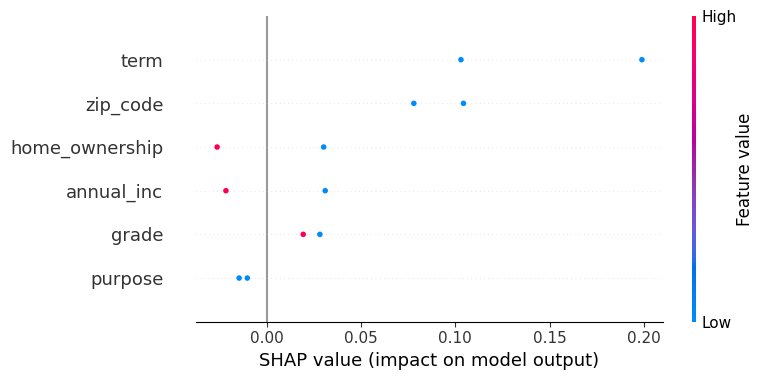

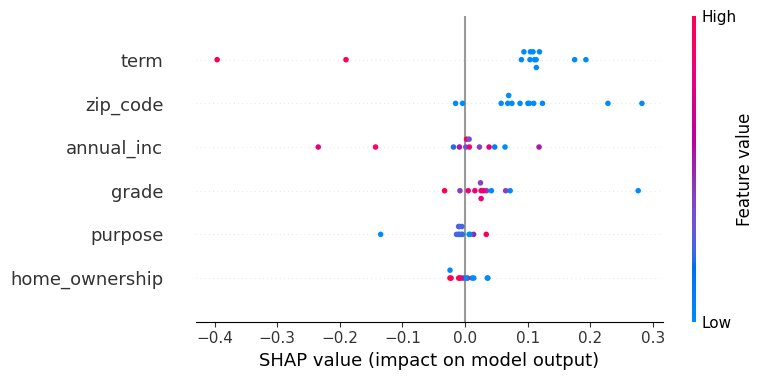

In [ ]:
explainer = shap.Explainer(clf.predict, X_df)
shap_values = explainer(X_df)

# Global plot
shap.summary_plot(shap_values, X_df)

# Subgroup masks
privileged_mask = X_df['zip_code'] == 1
unprivileged_mask = X_df['zip_code'] == 0

# Convert masks to indices
privileged_indices = np.where(privileged_mask)[0]
unprivileged_indices = np.where(unprivileged_mask)[0]

print("Privileged rows:", len(privileged_indices))
print("Unprivileged rows:", len(unprivileged_indices))

# Subgroup SHAP plots
shap.summary_plot(shap_values[privileged_indices], X_df.iloc[privileged_indices])
shap.summary_plot(shap_values[unprivileged_indices], X_df.iloc[unprivileged_indices])

## Save Results

In [ ]:

results = {
    'Accuracy': accuracy_score(y, y_pred),
    'Precision': precision_score(y, y_pred),
    'Recall': recall_score(y, y_pred),
    'F1': f1_score(y, y_pred),
    'AUC': roc_auc_score(y, y_prob),
    'SPD': metric.statistical_parity_difference(),
    'DI': metric.disparate_impact(),
    'EOD': metric.equal_opportunity_difference(),
    'AOD': metric.average_odds_difference(),
    'BiasAmp': metric.between_group_generalized_entropy_index(),
    'Theil': metric.theil_index()
}
pd.DataFrame([results]).to_csv('/content/drive/MyDrive/Research_Thesis_Implementation/exp5_xgb_baseline_results.csv', index=False)
